In [131]:
import pandas as pd
import twint
from pytrends.request import TrendReq
pytrends = TrendReq(backoff_factor=0.5)
%run -i 'mod5_functions.py'
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
sns.set(style="ticks", context="talk")
sns.set_context("talk")
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import math
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import ttest_ind
from sklearn.model_selection import TimeSeriesSplit
from fuzzywuzzy import fuzz, process
from sklearn.metrics import auc

## Data Mining

---

This process uses `pytrends` by General Mills to scrape Google Trends for its data. It has many methods you can use. First, I want to explore the search term *indoor farming* because urban agriculture's core is indoor farming, so I would like to see what I can find when I use the `related_topics()` method to find related search terms to *indoor farming*.

In [27]:
# First build the payload for pytrends
# pytrends.build_payload(['indoor farming'], geo='US')

# # Then get the related terms
# pytrends.related_topics()

I want to pick some of the more related terms to indoor farming, such as growing methods that I can find in this list.    

It is interesting to see some of the other related topics. I am going to insert *aeroponic* because AeroFarms came up in some of the results, and aeroponic growing is a great method for growing plants.

Going to use `fuzzywuzzy` to see if there are any differences between different forms of the search terms I am using.

In [4]:
print('Hydroponic(s): ',fuzz.partial_ratio('hydroponic', 'hydroponics'))
print('Aeroponic(s): ',fuzz.partial_ratio('aeroponic', 'aeroponics'))
print('Indoor farm(ing): ',fuzz.partial_ratio('indoor farm', 'indoor farming'))
print('Vertical Farm(ing): ',fuzz.partial_ratio('vertical farm', 'vertical farming'))

Hydroponic(s):  100
Aeroponic(s):  100
Indoor farm(ing):  100
Vertical Farm(ing):  100


Going to just use the singular forms of these words.

* vertical farming
* urban agriculture
* hydroponic
* greenhouse
* aeroponic

Now I am going to get all of the data for the search terms, including *indoor farm*. 

In [2]:
# Using the get_int() function to retrieve the historical interest index for my key terms
indoor_farming_int = get_int('indoor farm', '2000-01-01 2020-05-18')
hydro_int = get_int('hydroponic', '2000-01-01 2020-05-18')
vertical_int = get_int('vertical farm', '2000-01-01 2020-05-18')
urban_ag_int = get_int('urban agriculture', '2000-01-01 2020-05-18')
aero_int = get_int('aeroponic', '2000-01-01 2020-05-18')
greenhaus_int = get_int('greenhouse', '2000-01-01 2020-05-18')

I am choosing to average these series together because it seems that one of these topics lends itself to the other. They are nearly synonymous, anecdotally. 

In [4]:
# Going to average these series together to get a whole topic understanding
master = (aero_int['aeroponic']+urban_ag_int['urban agriculture']+vertical_int['vertical farm']+
          hydro_int['hydroponic']+indoor_farming_int['indoor farm']+
          greenhaus_int['greenhouse'])/6

In [5]:
# Going to turn this into a dataframe and change the index column name
master = master.to_frame()
master = rename_column(master, 0, 'interest')

In [74]:
# master.to_csv('remastered.csv')

---

In [5]:
# Loading and processing the previously saved CSV
master = pd.read_csv('remastered.csv')
master['date'] = pd.to_datetime(master['date'])
# Making a copy of this data for input to my cross validation function
master_2 = master.copy()
# Formatting the master data frame to be used in my SARIMA modeling
master.set_index('date', inplace=True)

----

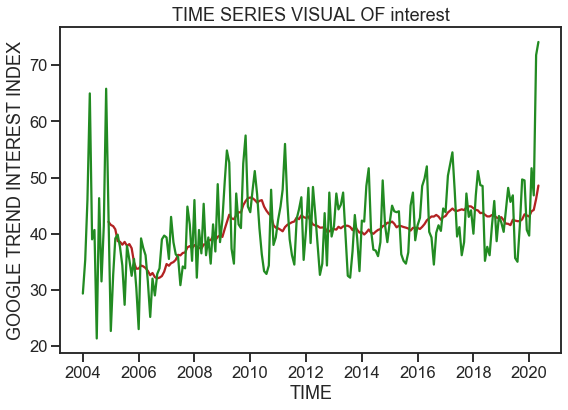

In [130]:
# Going to look at the time series plot
nice_plot(master, 'interest', 12)

In [131]:
# Using a function to perform the Dicky Fuller Test
gen_dftest(master, 'interest')

Test Stat                -0.808468
P-Value                   0.816622
# Lags                   13.000000
# Observations          183.000000
Critical Value (1%)      -3.466598
Critical Value (5%)      -2.877467
Critical Value (10%)     -2.575260
dtype: float64

This time series is not stationary, p-value > 0.05

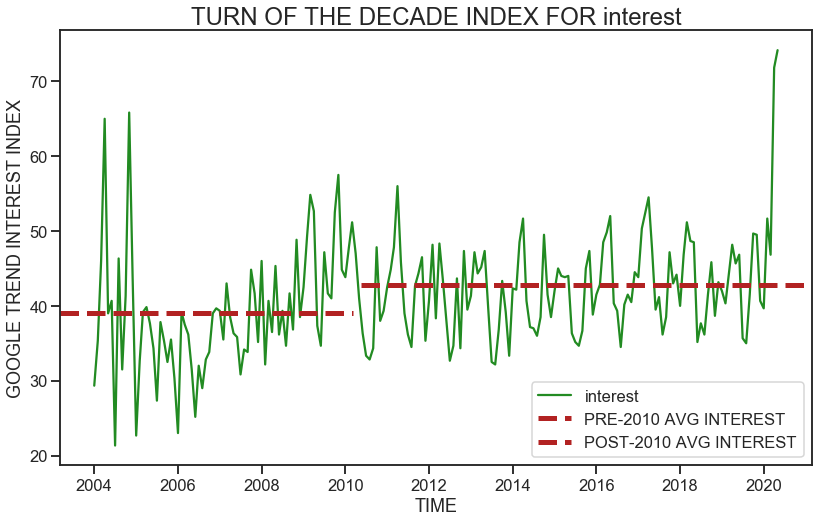

In [133]:
# Looking at the pre and post 2010 average interest index
# Want to visualize the difference in average of the pre and post 2010 index average
rolling_stats(master, 'interest')

Going to run a two-sampled Welsh's T-Test on the pre and post 2010 interest index averages.

In [134]:
ttest_ind(master[:'2009']['interest'], master['2010':]['interest'], equal_var=False)

Ttest_indResult(statistic=-3.4595675943453297, pvalue=0.0007465550020896306)

Even though there seems to be some outlying data in the beginning, the p-value is still less than 0.05, which indicates to me that the average pre-2010 is significantly different than post-2010. And in this case, assuming the average pre-2010 is less.

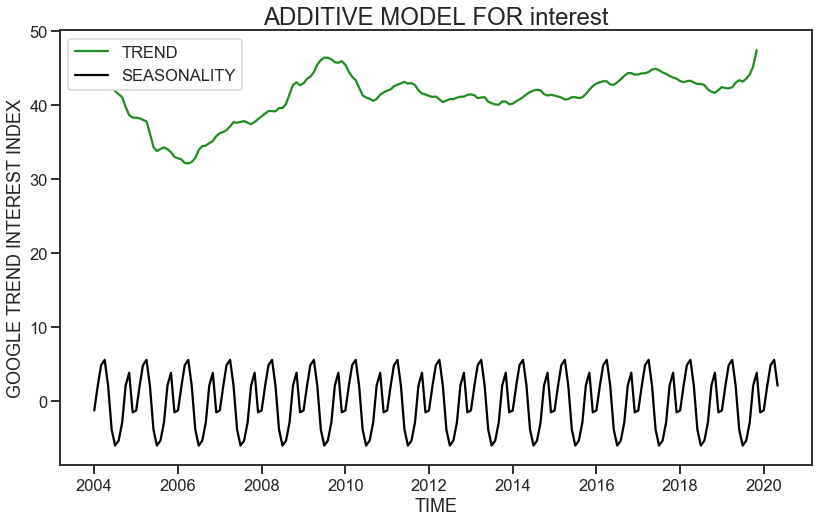

In [136]:
# Using a pre-defined function to look into the seasonal decomposition of the time series
# Uses statsmodels.tsa.seasonal.seasonal_decompose to accomplish
szn_decomp(master, 'interest', model=['additive'],
           graphs=['trend', 'szn'])

Seems to have an annual seasonality component. Interesting how it seems to peak just before year end and then again right after year end.

(<Figure size 1152x216 with 1 Axes>, <Figure size 1152x216 with 1 Axes>)

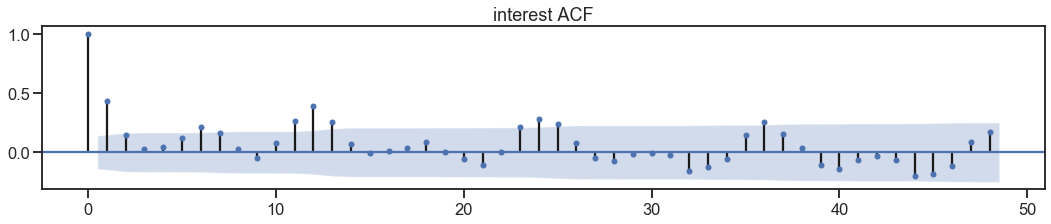

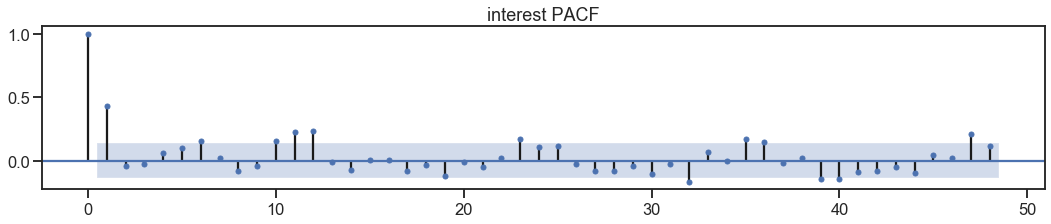

In [137]:
# Using pre-defined function to look into the ACF and PACF graphs
auto_corrs(master, 'interest')

More indication of a 12 month seasonality component

---

## The below code will train, fit, and evaluate models.
`make_chart()` creates a data frame of all of the required evaluation metrics, to be saved for later.

### Baseline Model

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:               interest   No. Observations:                  168
Model:                        SARIMAX   Log Likelihood                -863.119
Date:                Tue, 26 May 2020   AIC                           1728.237
Time:                        20:29:36   BIC                           1731.361
Sample:                    01-01-2004   HQIC                          1729.505
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1698.2326    744.074      2.282      0.022     239.874    3156.591
Ljung-Box (Q):                      180.98   Jarque-Bera (JB):                13.77
Prob(Q):                              0.00   Pr

,baseline model
AIC,1728.237032
BIC,1731.360996
MAE,40.602183
TRAIN RMSE,41.209618
TEST RMSE,46.271221


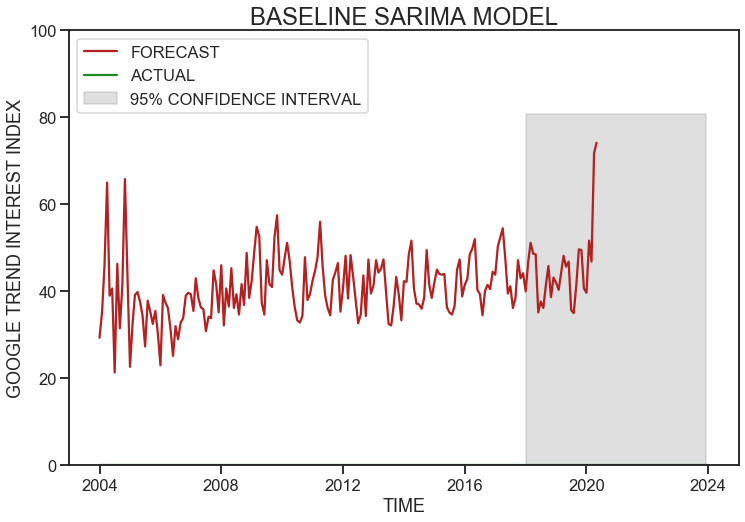

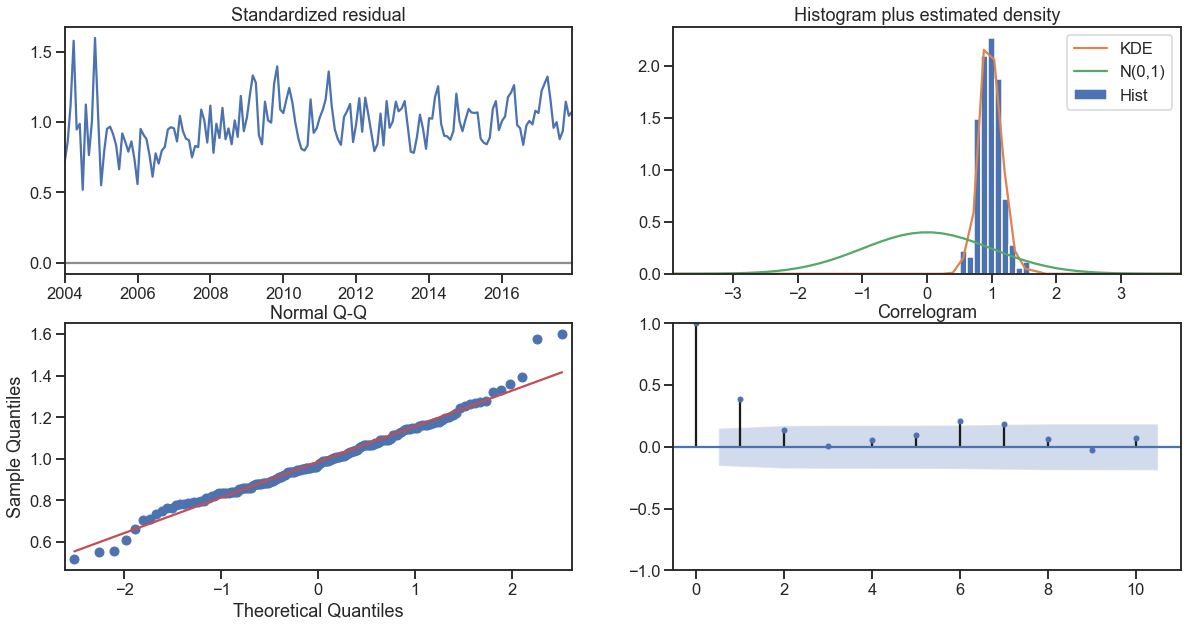

In [32]:
# Baseline SARIMA model with no ordering changes
# Just data by itself
baseline = SARIMAX(master['2004':'2017'], order=(0,0,0))
fit = baseline.fit()
print(fit.summary())
forecast = fit.predict(start='2004-01-01', end='2024-01-01')
print('\nForecasting 72 months into the future from the\ntraining data (2018 - 2024)\n.....\n....\n...\n..\n.')
forecast = pd.DataFrame(forecast)
forecast = rename_column(forecast, 0, 'forecast')
prediction = fit.get_forecast(steps=72)
pred_conf = prediction.conf_int()
# Plot the nice graphs
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=master['2004':].index,
             y=master['2004':]['interest'], color='firebrick')
sns.lineplot(x=forecast.index, y=forecast['forecast'], color='forestgreen')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.25)
plt.legend(['FORECAST','ACTUAL', '95% CONFIDENCE INTERVAL'], loc='upper left')
plt.xlabel('TIME',size=18)
plt.ylabel('GOOGLE TREND INTEREST INDEX', size=18)
plt.ylim(0,100)
plt.title('BASELINE SARIMA MODEL', size=24)
baseline_scores = make_chart(fit, master, 'baseline model')
print(fit.plot_diagnostics(figsize=(20,10)))
baseline_scores

In [29]:
# Using the function cross_val_ts() to cross validate the evaluation metrics
# Using master_2 dataframe for this function
base_rmse, base_aic, base_mae, base_mape, base_bic = cross_val_ts(master_2, 10, (0,0,0), (0,0,0,0))

Cross validated average RMSE on test data is: 25.251575527128203

 Cross validated average AIC for this model is: 917.8575408128327

  Cross validated average BIC for this model is: 922.8475630191224

  Cross validated average MAE for this model is: 16.208002442736195

   Cross validated average MAPE for this model is: 62.0% 

That didn't seem to forecast anything, so I am going to look into one order of differencing for my next model.

---

### Model 1 - employing one order of differencing  
May need to use this model as my baseline because my initial baseline didn't predict anything.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:               interest   No. Observations:                  168
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -579.419
Date:                Tue, 26 May 2020   AIC                           1160.839
Time:                        20:29:42   BIC                           1163.957
Sample:                    01-01-2004   HQIC                          1162.104
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        60.4173      5.174     11.677      0.000      50.277      70.558
Ljung-Box (Q):                       83.69   Jarque-Bera (JB):                11.42
Prob(Q):                              0.00   Pr

,model 1
AIC,1160.838565
BIC,1163.956559
MAE,6.032738
TRAIN RMSE,8.073376
TEST RMSE,9.038339


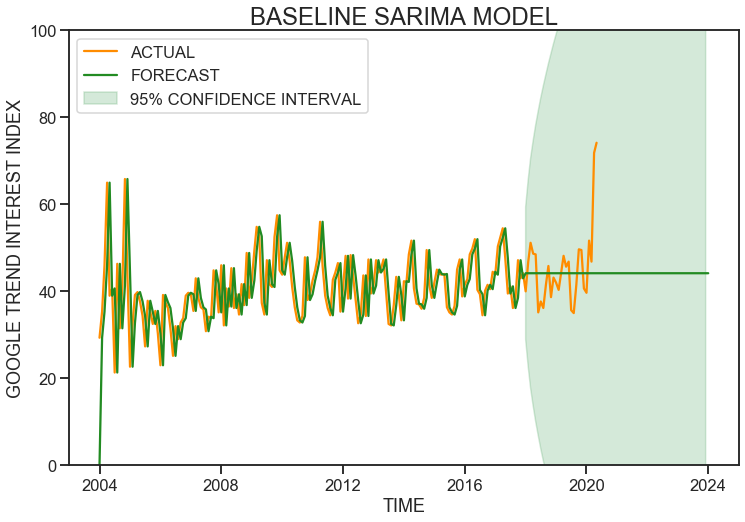

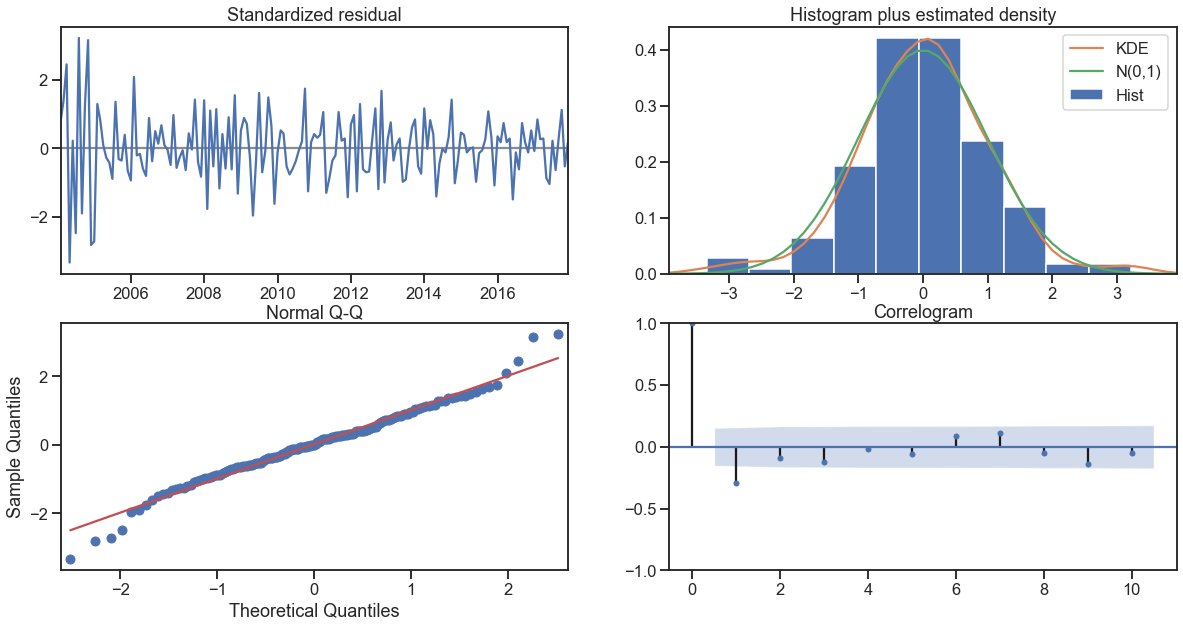

In [33]:
baseline = SARIMAX(master['2004':'2017'], order=(0,1,0))
fit = baseline.fit()
print(fit.summary())
forecast = fit.predict(start='2004-01-01', end='2024-01-01')
print('\nForecasting 72 months into the future from the\ntraining data (2018 - 2024)\n.....\n....\n...\n..\n.')
forecast = pd.DataFrame(forecast)
forecast = rename_column(forecast, 0, 'forecast')
prediction = fit.get_forecast(steps=72)
pred_conf = prediction.conf_int()
# Plot the nice graphs
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=master['2004':].index,
             y=master['2004':]['interest'], color='darkorange')
sns.lineplot(x=forecast.index, y=forecast['forecast'], color='forestgreen')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.25)
plt.legend(['ACTUAL', 'FORECAST', '95% CONFIDENCE INTERVAL'], loc='upper left')
plt.xlabel('TIME',size=18)
plt.ylabel('GOOGLE TREND INTEREST INDEX', size=18)
plt.ylim(0,100)
plt.title('BASELINE SARIMA MODEL', size=24)
model_1_scores = make_chart(fit, master, 'model 1')
print(fit.plot_diagnostics(figsize=(20,10)))
model_1_scores

In [133]:
mod1_rmse, mod1_aic, mod1_mae, mod1_mape, mod1_bic = cross_val_ts(master_2, 10, (0,1,0), (0,0,0,0))

Cross validated average RMSE on test data is: 7.403152505579295

 Cross validated Area Under Curve AIC for this model is: 35330.84482684046

  Cross validated Area Under Curve BIC for this model is: 36127.771452165776

  Cross validated average MAE for this model is: 7.459088218755847

   Cross validated average MAPE for this model is: 14.0% 

---

### Model 2 - employing one order of differencing, and one order of seasonal differencing with an **m value** = 12 for annual seasonality

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                           interest   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -550.560
Date:                            Tue, 26 May 2020   AIC                           1103.121
Time:                                    20:29:49   BIC                           1106.164
Sample:                                01-01-2004   HQIC                          1104.357
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        71.2483      7.670      9.289      0.000      56.215      86.282
Ljung-Box (Q):                     

,eda based model
AIC,1103.120616
BIC,1106.164041
MAE,7.529765
TRAIN RMSE,9.993097
TEST RMSE,7.402172


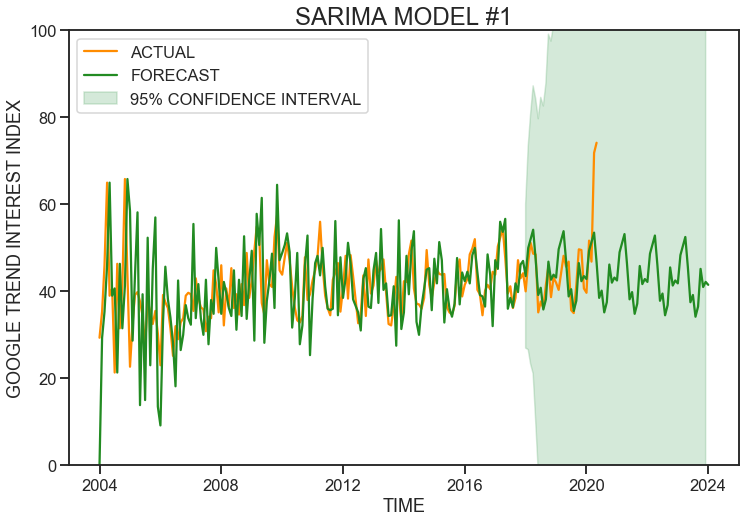

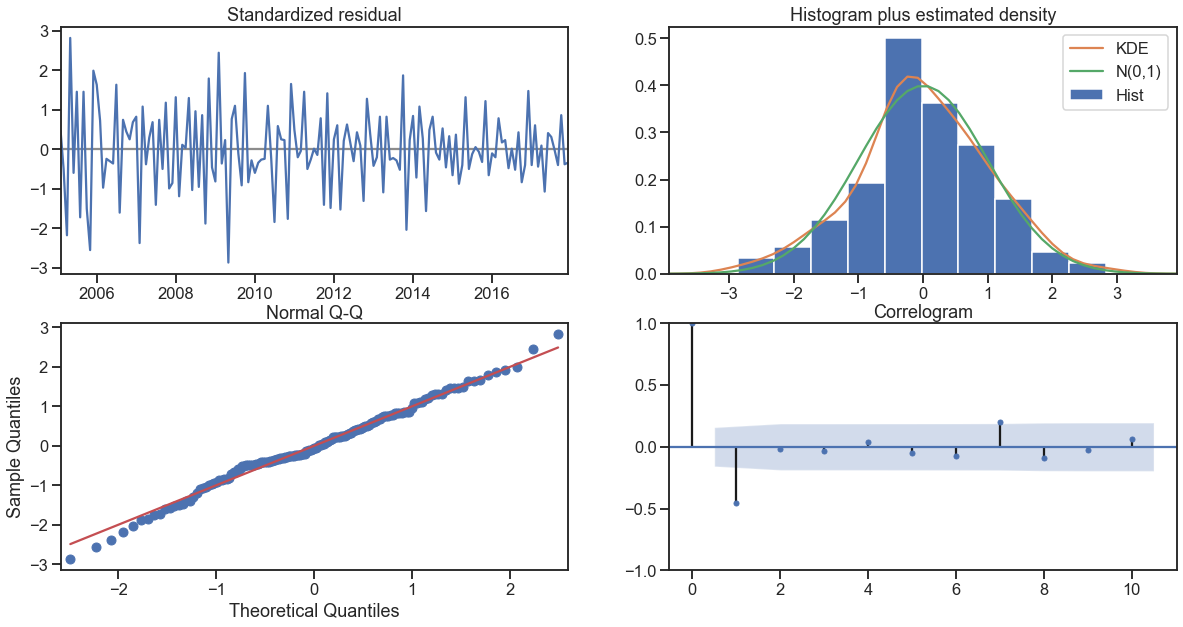

In [34]:
model = SARIMAX(master['2004':'2017'], order=(0,1,0), seasonal_order=(0, 1, 0, 12))
fit = model.fit()
print(fit.summary())
forecast = fit.predict(start='2004-01-01', end='2024-01-01')
print('\nForecasting 72 months into the future from the\ntraining data (2018 - 2024)\n.....\n....\n...\n..\n.')
forecast = pd.DataFrame(forecast)
forecast = rename_column(forecast, 0, 'forecast')
prediction = fit.get_forecast(steps=72)
pred_conf = prediction.conf_int()
# Plot the nice graphs
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=master['2004':].index,
             y=master['2004':]['interest'], color='darkorange')
sns.lineplot(x=forecast.index, y=forecast['forecast'], color='forestgreen')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.25)
plt.legend(['ACTUAL', 'FORECAST', '95% CONFIDENCE INTERVAL'], loc='upper left')
plt.xlabel('TIME',size=18)
plt.ylabel('GOOGLE TREND INTEREST INDEX', size=18)
plt.ylim(0,100)
plt.title('SARIMA MODEL #1', size=24)
eda_based_model = make_chart(fit, master, 'eda based model')
print(fit.plot_diagnostics(figsize=(20,10)))
eda_based_model

In [135]:
mod2_rmse, mod2_aic, mod2_mae, mod2_mape, mod2_bic = cross_val_ts(master_2, 10, (0,1,0), (0,1,0,12))

Cross validated average RMSE on test data is: 9.919059631923911

 Cross validated Area Under Curve AIC for this model is: 14250.97016521748

  Cross validated Area Under Curve BIC for this model is: 14576.286938957255

  Cross validated average MAE for this model is: 9.890857659807024

   Cross validated average MAPE for this model is: 20.0%

---

## auto_arima Modeling  
Utilizing `auto_arima` to gridsearch through the best parameters for the ordering of the SARIMA model

### Auto Mod 1 - default setting of one order of differencing 

In [36]:
# Searching for best params
# I want the search to start from zero on the (pq) and (PQ) fronts
# Will be including default one order of differencing and seasonality
model = auto_arima(master['2004':'2017'], trace=True, start_p=0, start_q=0, d=1,
                  start_P=0, start_Q=0, seasonal=True, m=12, suppress_warnings=True, 
                   D=1, error_action='ignore', approximation=False, trend='t', random_state=42)
fitted = model.fit(master['2004':'2017'])

# auto_arima models have a .get_params method to get the best parameters based on AIC reduction
best_params = fitted.get_params()
print('\n\nThe best order parameters are {},{}\n'.format(best_params['order'],best_params['seasonal_order']))

The best order parameters are (0, 1, 1),(0, 1, 1, 12)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                           interest   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -497.418
Date:                            Tue, 26 May 2020   AIC                           1002.837
Time:                                    20:25:48   BIC                           1015.010
Sample:                                01-01-2004   HQIC                          1007.781
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       9.528e-05      0.001      0.190      0.849      -0.001       0.001
ma.L1         -0.8306      0.050   

,auto model 1
AIC,1002.836579
BIC,1015.010280
MAE,5.689667
TRAIN RMSE,8.380198
TEST RMSE,6.871997


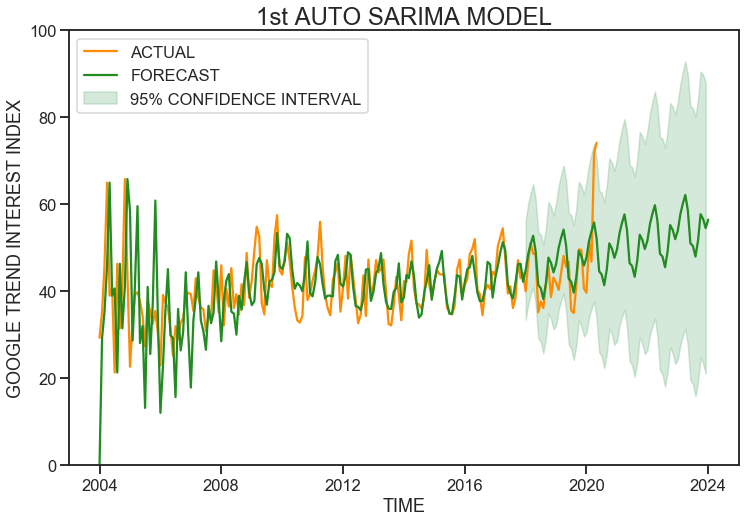

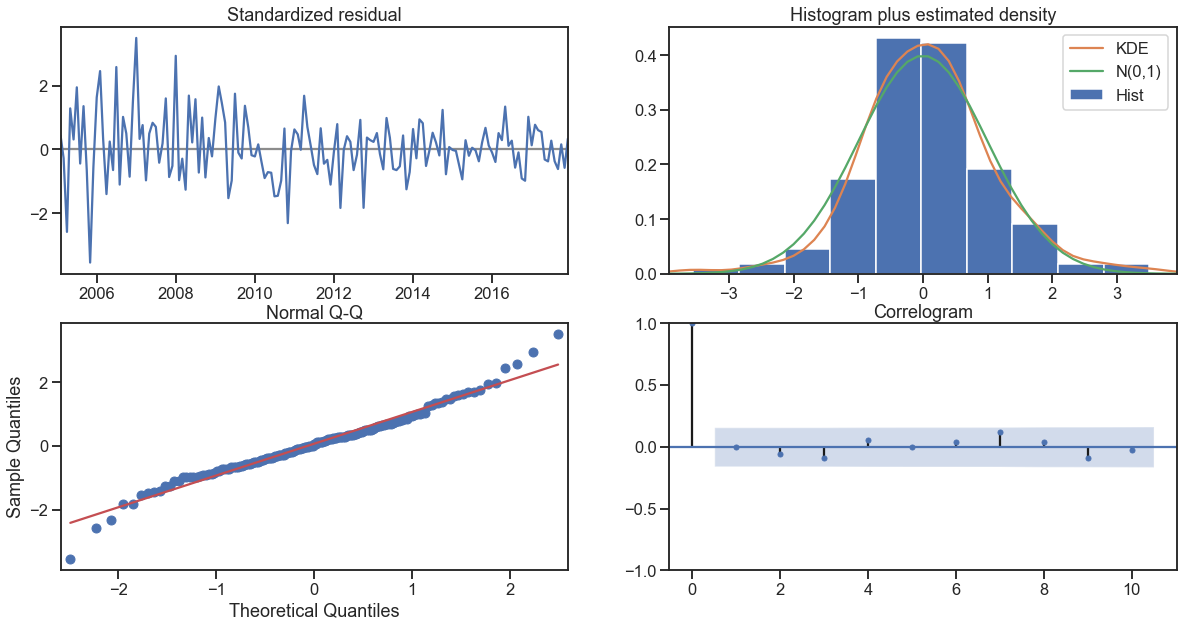

In [24]:
auto_mod1 = SARIMAX(master['2004':'2017'], order=(0,1,1), seasonal_order=(0,1,1,12),
                trend='t')
fit = auto_mod1.fit()
print(fit.summary())
forecast = fit.predict(start='2004-01-01', end='2024-01-01')
print('\nForecasting 72 months into the future from the\ntraining data (2018 - 2024)\n.....\n....\n...\n..\n.')
forecast = pd.DataFrame(forecast)
forecast = rename_column(forecast, 0, 'forecast')
prediction = fit.get_forecast(steps=72)
pred_conf = prediction.conf_int()
# Plot the nice graphs
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=master['2004':].index,
             y=master['2004':]['interest'], color='darkorange')
sns.lineplot(x=forecast.index, y=forecast['forecast'], color='forestgreen')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.25)
plt.legend(['ACTUAL', 'FORECAST', '95% CONFIDENCE INTERVAL'], loc='upper left')
plt.xlabel('TIME',size=18)
plt.ylabel('GOOGLE TREND INTEREST INDEX', size=18)
plt.ylim(0,100)
plt.title('1st AUTO SARIMA MODEL', size=24)

auto_mod_1 = make_chart(fit, master, 'auto model 1')
print(fit.plot_diagnostics(figsize=(20,10)))
auto_mod_1

In [137]:
automod1_rmse, automod1_aic, automod1_mae, automod1_mape, automod1_bic = cross_val_ts(master_2, 10, (0,1,1), (0,1,1,12))

Cross validated average RMSE on test data is: 7.950430779771301

 Cross validated Area Under Curve AIC for this model is: 13188.071282749128

  Cross validated Area Under Curve BIC for this model is: 13818.171666938293

  Cross validated average MAE for this model is: 7.931980334720483

   Cross validated average MAPE for this model is: 16.0% 

---

### Auto Mod 2 - includes no default setting for differencing

In [40]:
model = auto_arima(master['2004':'2017'], trace=True, start_p=0, start_q=0,
                  start_P=0, start_Q=0, seasonal=True, m=12, suppress_warnings=True,
                   error_action='ignore', approximation=False, trend='t', random_state=42)
fitted = model.fit(master['2004':'2017'])
best_params = fitted.get_params()
print('\n\nThe best order parameters are {},{}\n'.format(best_params['order'],best_params['seasonal_order']))

The best order parameters are (0, 1, 1),(2, 0, 2, 12)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                        SARIMAX Results                                        
Dep. Variable:                                interest   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                -530.358
Date:                                 Tue, 26 May 2020   AIC                           1074.716
Time:                                         20:26:00   BIC                           1096.542
Sample:                                     01-01-2004   HQIC                          1083.575
                                          - 12-01-2017                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0002      0.001      0.394      0.694      -0.001       0

,auto model 2
AIC,1074.715983
BIC,1096.541940
MAE,4.566372
TRAIN RMSE,6.587574
TEST RMSE,7.140279


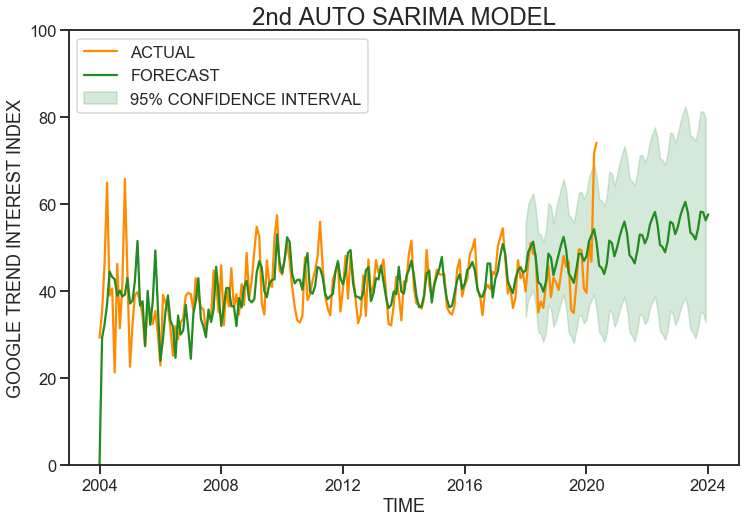

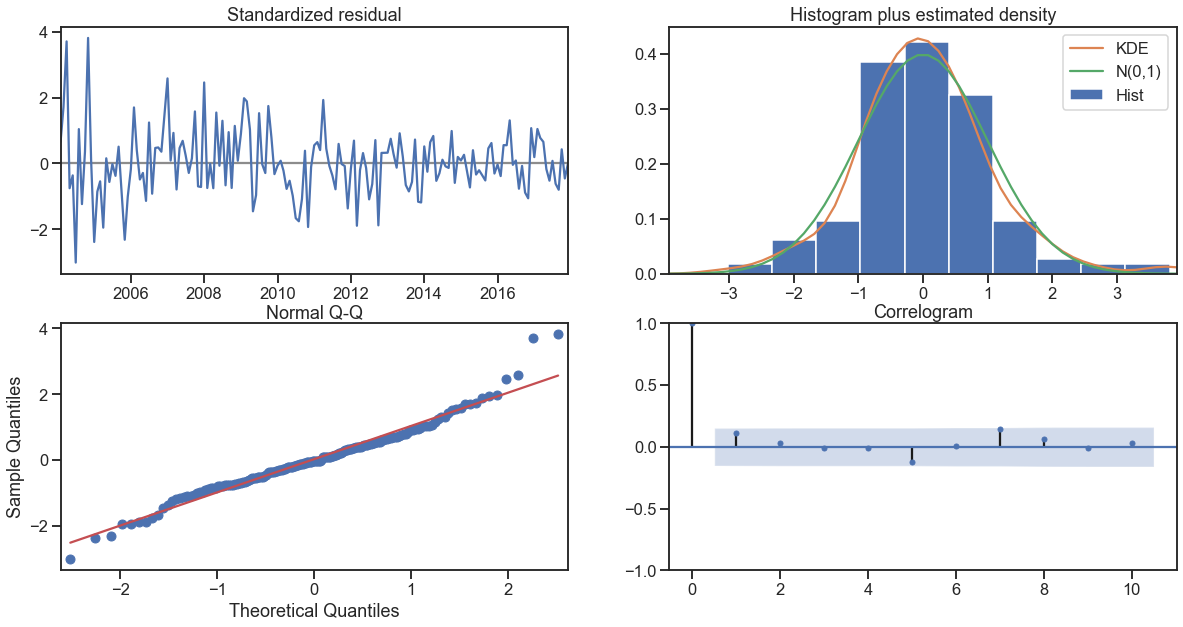

In [25]:
auto_mod2 = SARIMAX(master['2004':'2017'], order=(0,1,1), seasonal_order=(2,0,2,12),
                trend='t')
fit = auto_mod2.fit()
print(fit.summary())
forecast = fit.predict(start='2004-01-01', end='2024-01-01')
print('\nForecasting 72 months into the future from the\ntraining data (2018 - 2024)\n.....\n....\n...\n..\n.')
forecast = pd.DataFrame(forecast)
forecast = rename_column(forecast, 0, 'forecast')
prediction = fit.get_forecast(steps=72)
pred_conf = prediction.conf_int()
# Plot the nice graphs
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=master['2004':].index,
             y=master['2004':]['interest'], color='darkorange')
sns.lineplot(x=forecast.index, y=forecast['forecast'], color='forestgreen')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.25)
plt.legend(['ACTUAL', 'FORECAST', '95% CONFIDENCE INTERVAL'], loc='upper left')
plt.xlabel('TIME',size=18)
plt.ylabel('GOOGLE TREND INTEREST INDEX', size=18)
plt.ylim(0,100)
plt.title('2nd AUTO SARIMA MODEL', size=24)

auto_mod_2 = make_chart(fit, master, 'auto model 2')
print(fit.plot_diagnostics(figsize=(20,10)))
auto_mod_2

In [139]:
automod2_rmse, automod2_aic, automod2_mae, automod2_mape, automod2_bic = cross_val_ts(master_2, 10, (0,1,1), (2,0,2,12))

Cross validated average RMSE on test data is: 6.6269329954465785

 Cross validated Area Under Curve AIC for this model is: 33137.75387560666

  Cross validated Area Under Curve BIC for this model is: 35878.07699196613

  Cross validated average MAE for this model is: 5.739227548836908

   Cross validated average MAPE for this model is: 13.0%  


---

### Auto Mod 3 - no specified starting parameter settings, using 'bfgs' solver

In [42]:
# Note that I have removed the starting parameters specifications
# Going to try the different methods
model = auto_arima(master['2004':'2017'], trace=True, seasonal=True, m=12, suppress_warnings=True,
                error_action='ignore', approximation=False, trend='t', method='bfgs', random_state=42)
fitted = model.fit(master['2004':'2017'])
best_params = fitted.get_params()
print('\n\nThe best order parameters are {},{}\n'.format(best_params['order'],best_params['seasonal_order']))

The best order parameters are (0, 1, 1),(1, 0, 1, 12)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                           interest   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -534.207
Date:                            Tue, 26 May 2020   AIC                           1078.415
Time:                                    20:24:03   BIC                           1094.005
Sample:                                01-01-2004   HQIC                          1084.743
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0001      0.001      0.245      0.807      -0.001       0.001
ma.L1         -0.8466      0.041   

,auto model 3
AIC,1078.414944
BIC,1094.004913
MAE,4.603199
TRAIN RMSE,6.635522
TEST RMSE,7.285354


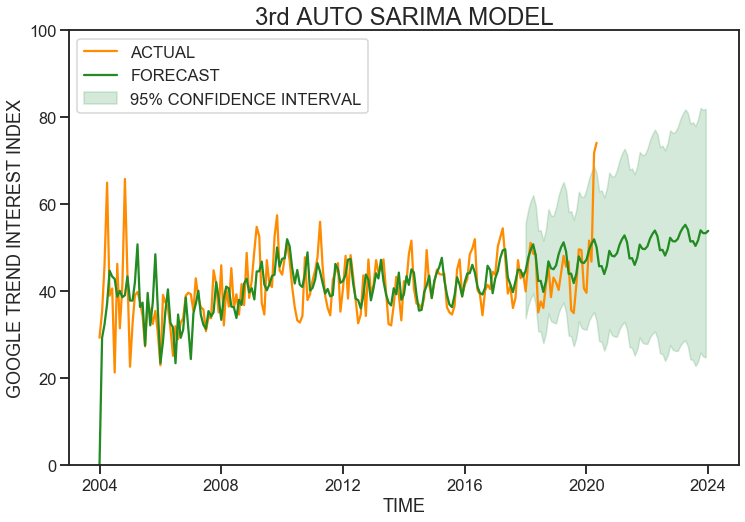

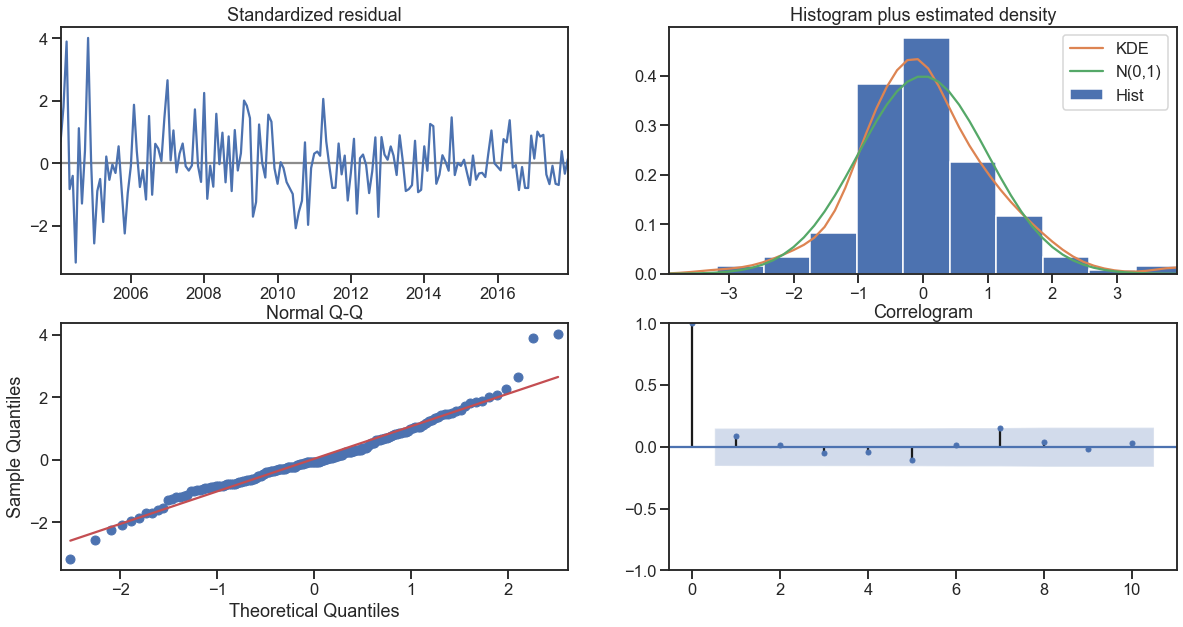

In [22]:
auto_mod3 = SARIMAX(master['2004':'2017'], order=(0,1,1), seasonal_order=(1,0,1,12),
                trend='t')
fit = auto_mod3.fit()
print(fit.summary())
forecast = fit.predict(start='2004-01-01', end='2024-01-01')
print('\nForecasting 72 months into the future from the\ntraining data (2018 - 2024)\n.....\n....\n...\n..\n.')
forecast = pd.DataFrame(forecast)
forecast = rename_column(forecast, 0, 'forecast')
prediction = fit.get_forecast(steps=72)
pred_conf = prediction.conf_int()
# Plot the nice graphs
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=master['2004':].index,
             y=master['2004':]['interest'], color='darkorange')
sns.lineplot(x=forecast.index, y=forecast['forecast'], color='forestgreen')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.25)
plt.legend(['ACTUAL', 'FORECAST', '95% CONFIDENCE INTERVAL'], loc='upper left')
plt.xlabel('TIME',size=18)
plt.ylabel('GOOGLE TREND INTEREST INDEX', size=18)
plt.ylim(0,100)
plt.title('3rd AUTO SARIMA MODEL', size=24)
auto_mod_3 = make_chart(fit, master, 'auto model 3')
print(fit.plot_diagnostics(figsize=(20,10)))
auto_mod_3

In [141]:
automod3_rmse, automod3_aic, automod3_mae, automod3_mape, automod3_bic = cross_val_ts(master_2, 10, (0,1,1), (1,0,1,12))

Cross validated average RMSE on test data is: 7.088990358543386

 Cross validated Area Under Curve AIC for this model is: 32158.937886674474

  Cross validated Area Under Curve BIC for this model is: 34076.9794813521

  Cross validated average MAE for this model is: 5.756975934436655

   Cross validated average MAPE for this model is: 14.0% 

---

### Auto Mod 4 - same as before, using powell solver

In [21]:
# # Trying the powell optimizer
model = auto_arima(master['2004':'2017'], trace=True, seasonal=True, m=12, suppress_warnings=True,
                error_action='ignore', approximation=False, trend='t', method='powell', random_state=42)
fitted = model.fit(master['2004':'2017'])
best_params = fitted.get_params()
print('\n\nThe best order parameters are {},{}\n'.format(best_params['order'],best_params['seasonal_order']))

Repeat parameters. Output omitted from GitHub commit.

---

### Auto Mod 5 - using same settings as before, but with default 'lbfgs' solver

In [20]:
# model = auto_arima(master['2004':'2017'], trace=True, seasonal=True, m=12, suppress_warnings=True,
#                 error_action='ignore', approximation=False, trend='t', random_state=42)
# fitted = model.fit(master['2004':'2017'])
# best_params = fitted.get_params()
# print('\n\nThe best order parameters are {},{}\n'.format(best_params['order'],best_params['seasonal_order']))

Repeat parameters. Output omitted from GitHub commit.

---

## Final Model Parameters to Compare

* baseline - (0,0,0)x(0,0,0,0)  
* model 1 - (0,1,0)x(0,0,0,0)  
* model 2 - (0,1,0)x(0,1,0,12)
* auto model 1 - (0,1,1)x(0,1,1,12)  
* auto model 2 - (0,1,1)x(2,0,2,12)
* auto model 3 - (1,1,1)x(1,0,1,12)  
  
The custom function `compare_scores()` creates a dictionary for each evaluation metric containing all of the other models' same evaluation metric.

In [181]:
aic = compare_scores('AIC', [baseline_scores,model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
bic = compare_scores('BIC', [baseline_scores,model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
mae = compare_scores('MAE', [baseline_scores,model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
train_rmse = compare_scores('TRAIN RMSE', [baseline_scores,model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
test_rmse = compare_scores('TEST RMSE', [baseline_scores,model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
metrics = [aic, bic, mae, train_rmse, test_rmse]

`score_chart()` just makes a bar graph for comparison.

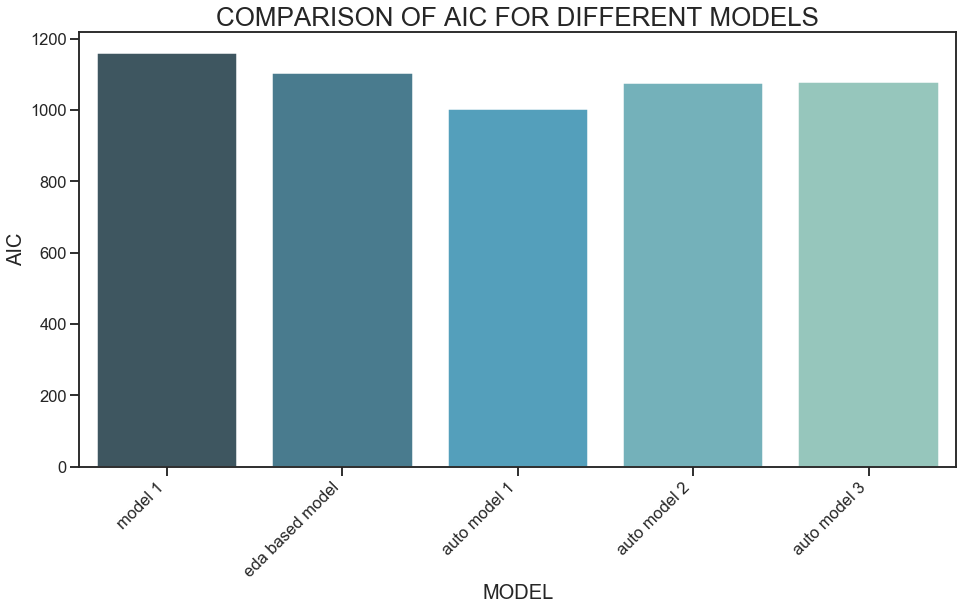

In [175]:
score_chart(list(aic.keys()), list(aic.values()), 'AIC')

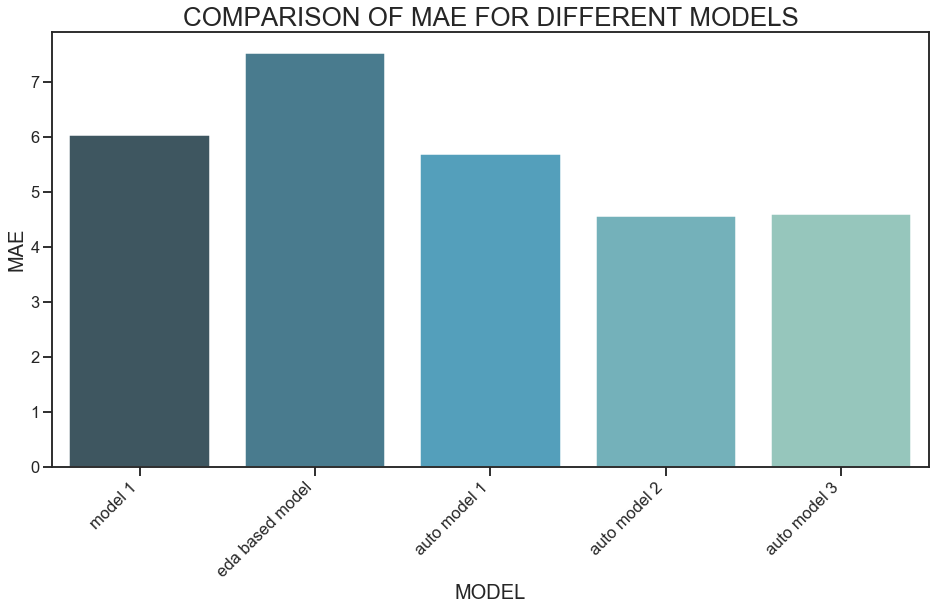

In [176]:
score_chart(list(mae.keys()), list(mae.values()),'MAE')

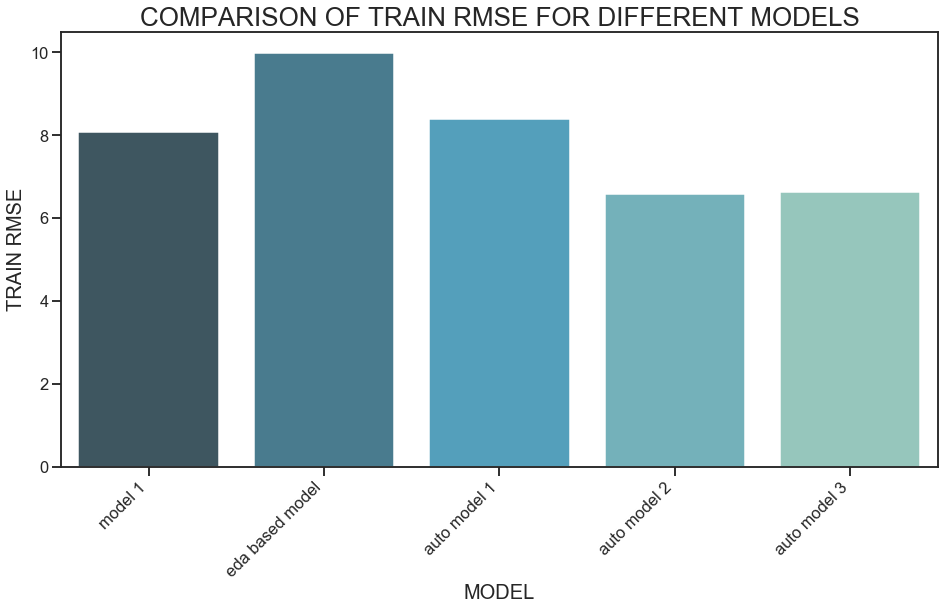

In [177]:
score_chart(list(train_rmse.keys()), list(train_rmse.values()), 'TRAIN RMSE')

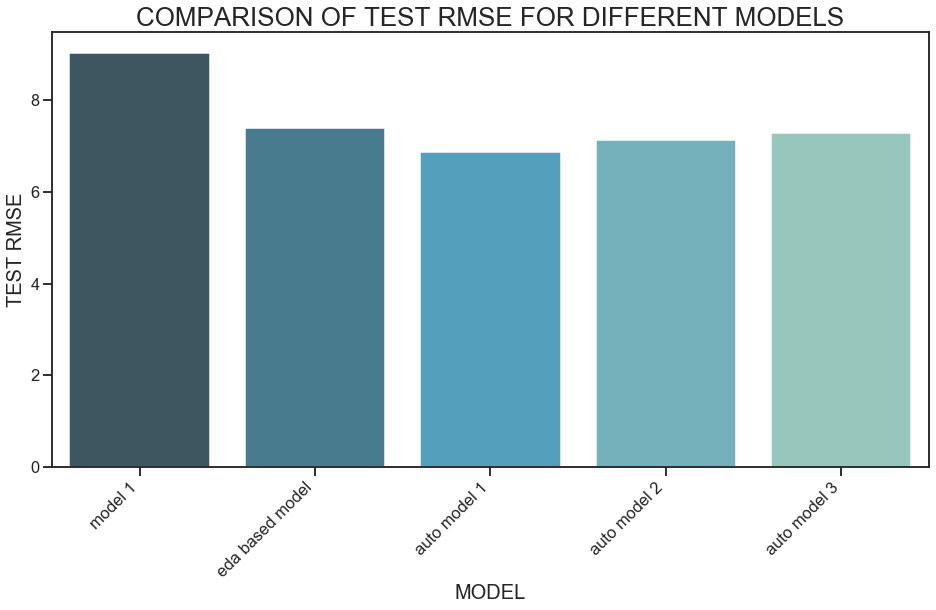

In [178]:
score_chart(list(test_rmse.keys()), list(test_rmse.values()), 'TEST RMSE')

Clearly all models performed much better than the baseline. I want to see what the breakdown looks like without the baseline affecting the y-axis scale.

In [113]:
# Same process as before, excluding that initial baseline model that did not predict anything
aic2 = compare_scores('AIC', [model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
bic2 = compare_scores('BIC', [model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
mae2 = compare_scores('MAE', [model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
train_rmse2 = compare_scores('TRAIN RMSE', [model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
test_rmse2 = compare_scores('TEST RMSE', [model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
metrics = [aic2, bic2, mae2, train_rmse2, test_rmse2]

In [122]:
mae2

{'model 1': 6.032738095238092,
 'eda based model': 7.529765014691866,
 'auto model 1': 5.689667447794447,
 'auto model 2': 4.566372082958591,
 'auto model 3': 4.603198943137005}

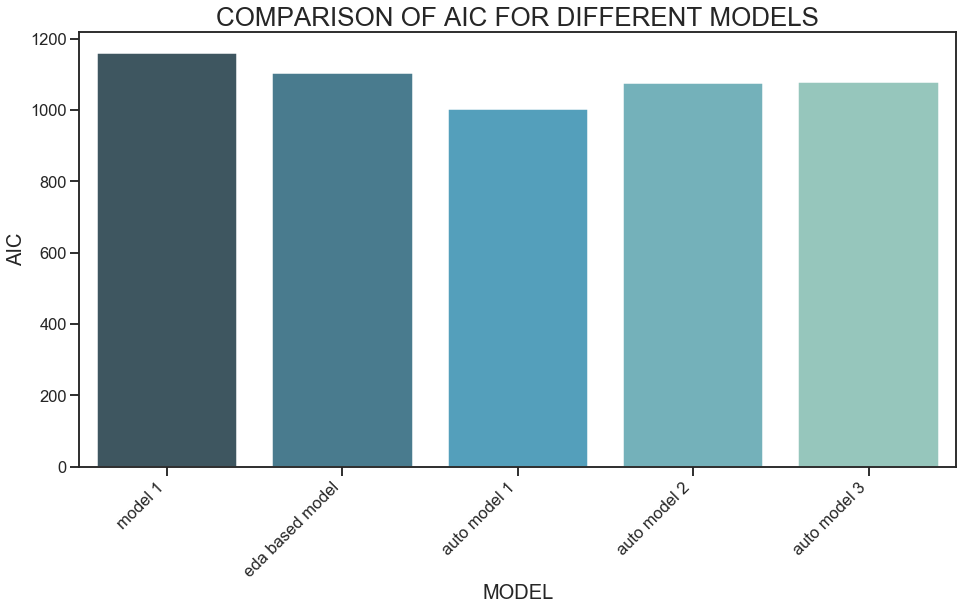

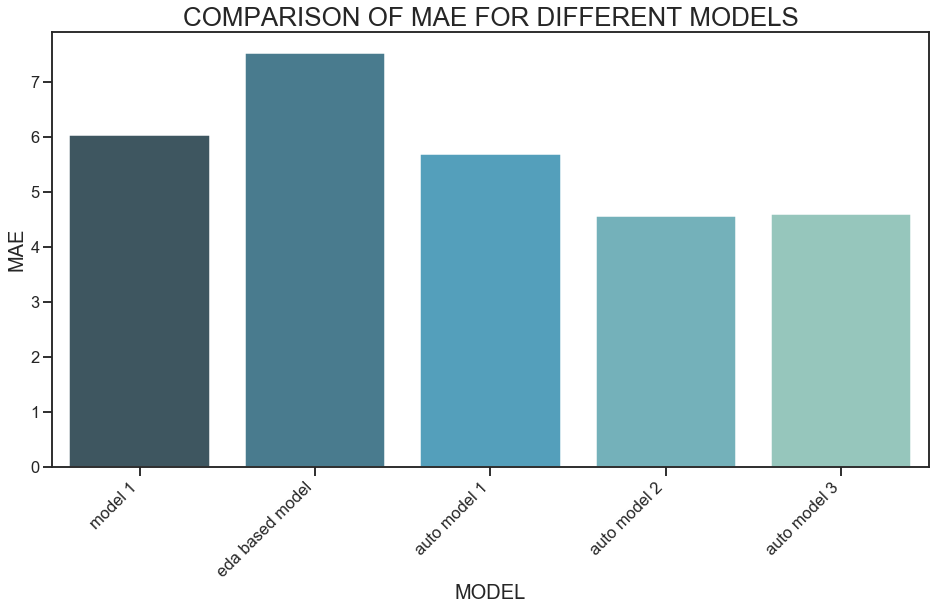

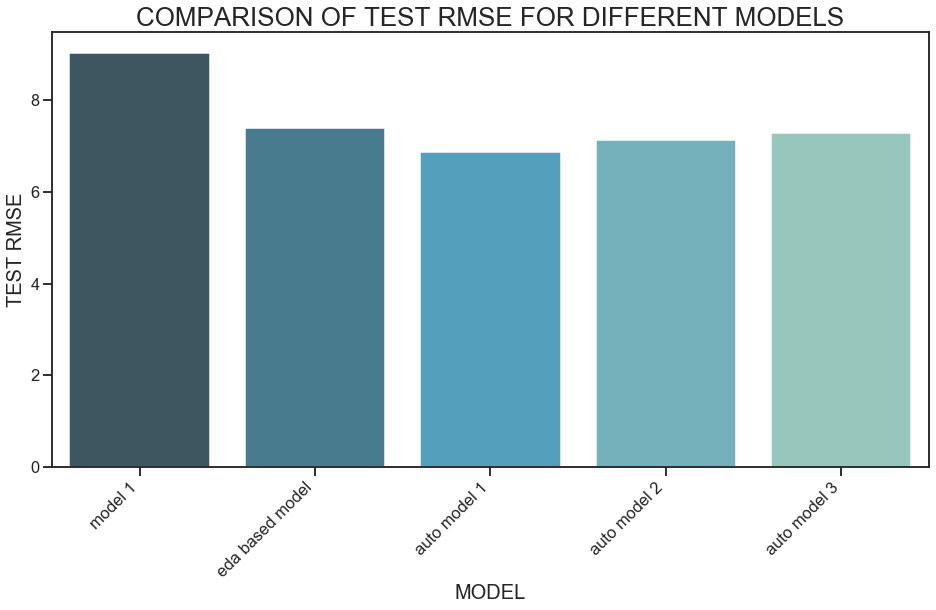

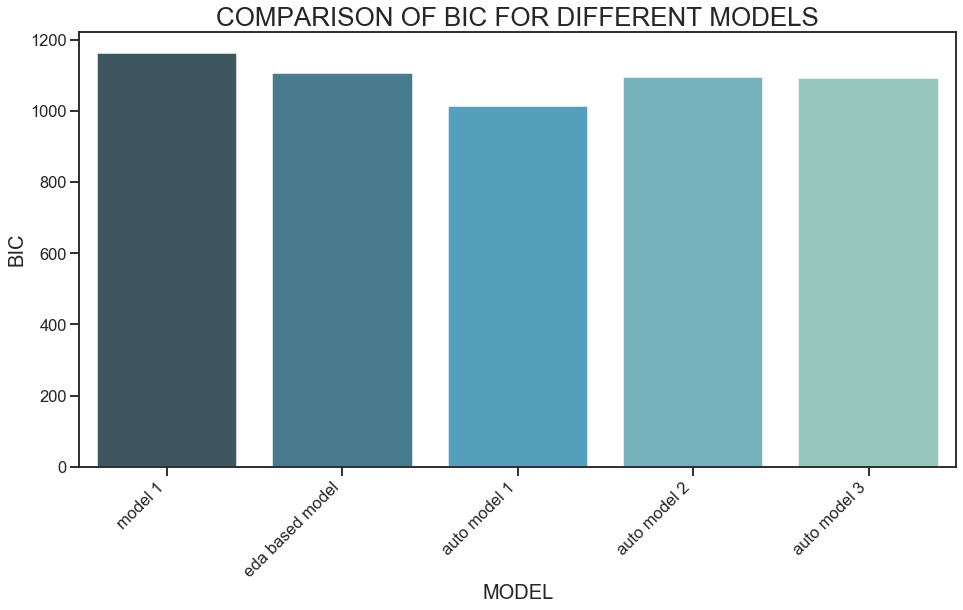

In [183]:
score_chart(list(aic2.keys()), list(aic2.values()), 'AIC')
score_chart(list(mae2.keys()), list(mae2.values()),'MAE')
score_chart(list(test_rmse2.keys()), list(test_rmse2.values()), 'TEST RMSE')
score_chart(list(bic2.keys()), list(bic2.values()), 'BIC')

The auto_model_1 has captured 3/4 wins for the evaluation metrics. AIC, BIC, and Test RMSE. It lost out on the MAE, but was still better than model 1 and eda based model.

---

### Evaluation Metrics Analysis

Going to calculate the percent improvement over one model to another. Going to make this somewhat open ended so I can look at differences between different models. I want to look into the improvements using `model 1` as my baseline due to there being no predictions coming from the original baseline model.  
  
`compare_models()` will compare any of the indicated models

In [223]:
# Baseline with EDA based model
compare_models('model 1', 'eda based model', 'MODEL 1', 'EDA BASED MODEL')

The percent improvements from MODEL 1 to EDA BASED MODEL,
 where a stronger negative number relates to higher improvement,
 are the following: 

AIC Improvements:  -4.972090952580286 
 BIC Improvements:  -4.965178255354422 
 MAE Improvments:  24.815049084186885 
 Test RMSE Improvements:  -18.102521645591494


In [224]:
# Baseline with auto_model_1
compare_models('model 1', 'auto model 1', 'MODEL 1', 'AUTO MODEL 1')

The percent improvements from MODEL 1 to AUTO MODEL 1,
 where a stronger negative number relates to higher improvement,
 are the following: 

AIC Improvements:  -13.611021430044822 
 BIC Improvements:  -12.796549670817594 
 MAE Improvments:  -5.686814876224218 
 Test RMSE Improvements:  -23.968366761873714


In [225]:
# Baseline with auto_model_2
compare_models('model 1', 'auto model 2', 'MODEL 1', 'AUTO MODEL 2')

The percent improvements from MODEL 1 to AUTO MODEL 2,
 where a stronger negative number relates to higher improvement,
 are the following: 

AIC Improvements:  -7.418997287537207 
 BIC Improvements:  -5.791850070798974 
 MAE Improvments:  -24.30680711030649 
 Test RMSE Improvements:  -21.000096566074323


In [226]:
# Baseline with auto_model_3
compare_models('model 1', 'auto model 3', 'MODEL 1', 'AUTO MODEL 3')

The percent improvements from MODEL 1 to AUTO MODEL 3,
 where a stronger negative number relates to higher improvement,
 are the following: 

AIC Improvements:  -7.100351722972335 
 BIC Improvements:  -6.009815853667575 
 MAE Improvments:  -23.69635693665346 
 Test RMSE Improvements:  -19.39498993408107


Clearly the best model based on the improvements made is auto_model_1 with the exception of MAE.

---

In [45]:
# Using the numbers generated during cross-validation to make a dictionary for each eval metric
cv_aic = {
    'baseline':base_aic, 'model_1':mod1_aic, 'model_2':mod2_aic, 'automod_1':automod1_aic,
       'automod_2':automod2_aic, 'automod_3':automod3_aic
}
cv_test_rmse = {
    'baseline':base_rmse, 'model_1':mod1_rmse, 'model_2':mod2_rmse, 'automod_1':automod1_rmse,
    'automod_2':automod2_rmse,
    'automod_3':automod3_rmse
}
cv_mae = {
    'baseline':base_mae, 'model_1':mod1_mae, 'model_2':mod2_mae, 'automod_1':automod1_mae,
    'automod_2':automod2_mae,
    'automod_3':automod3_mae
}
cv_mape = {
    'baseline':base_mape, 'model_1':mod1_mape, 'model_2':mod2_mape, 'automod_1':automod1_mape,
    'automod_2':automod2_mape,
    'automod_3':automod3_mape
}
cv_bic = {
    'baseline':base_bic, 'model_1':mod1_bic, 'model_2':mod2_bic, 'automod_1':automod1_bic,
    'automod_2':automod2_bic,
    'automod_3':automod3_bic
}

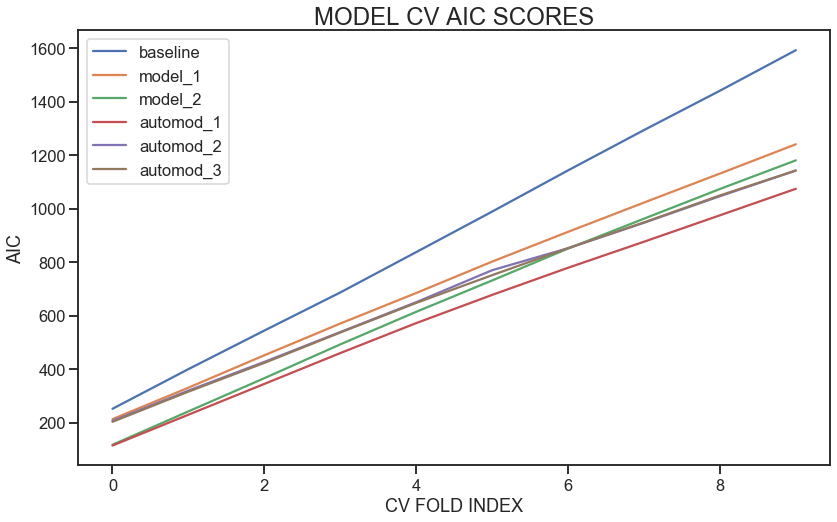

In [210]:
plot_models('AIC', 'MODEL CV AIC SCORES',model_eval=[list for list in cv_aic.values()],
            labels=list(cv_aic.keys()))

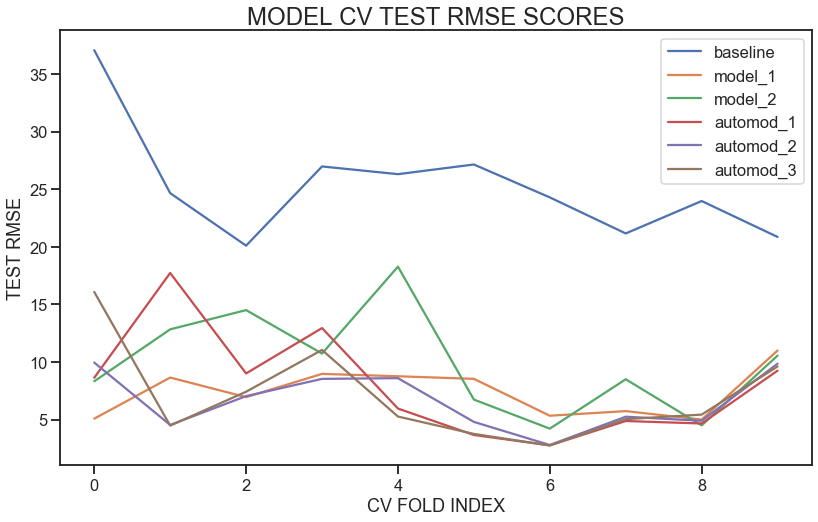

In [211]:
plot_models('TEST RMSE', 'MODEL CV TEST RMSE SCORES',model_eval=[list for list in cv_test_rmse.values()],
            labels=list(cv_test_rmse.keys()))

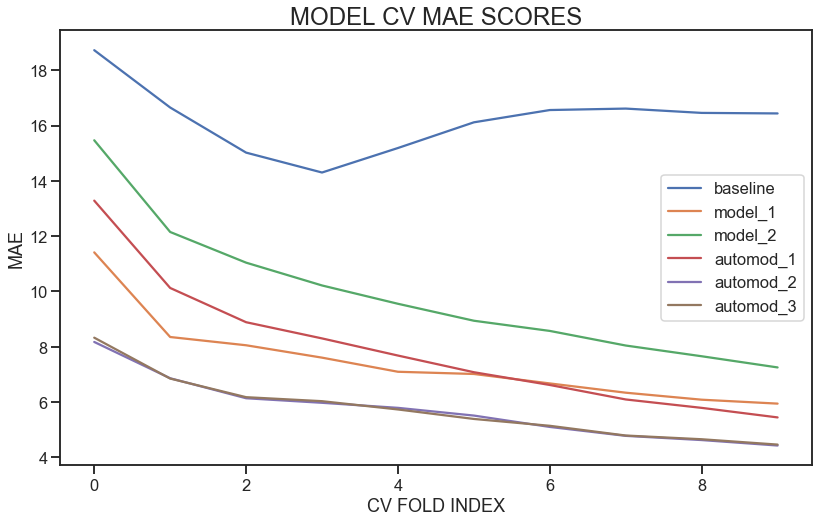

In [212]:
plot_models('MAE', 'MODEL CV MAE SCORES',model_eval=[list for list in cv_mae.values()],
            labels=list(cv_mae.keys()))

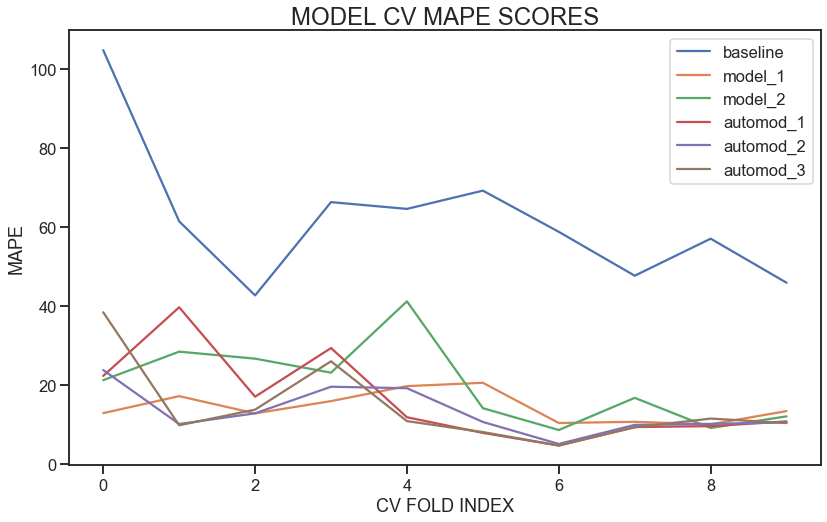

In [213]:
plot_models('MAPE', 'MODEL CV MAPE SCORES',model_eval=[list for list in cv_mape.values()],
            labels=list(cv_mape.keys()))

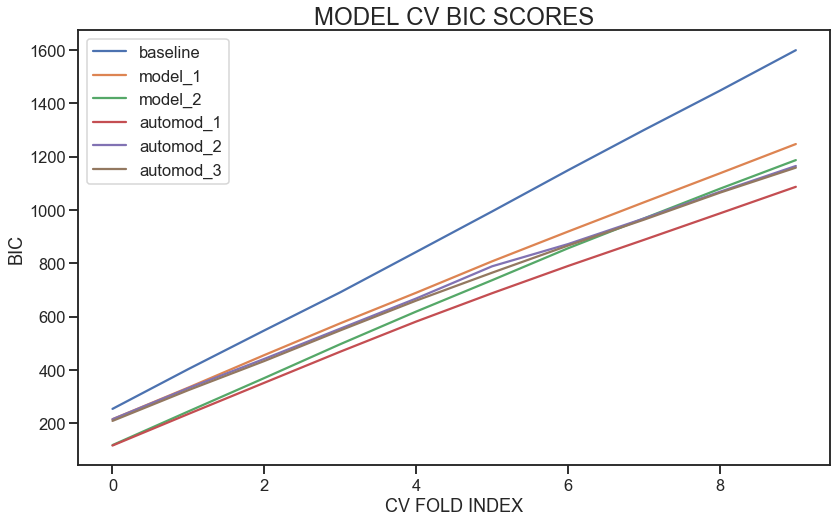

In [214]:
plot_models('BIC', 'MODEL CV BIC SCORES',model_eval=[list for list in cv_bic.values()],
            labels=list(cv_bic.keys()))

Would like to see what would happen if I removed the baseline model from this analysis. It might change the y-axis and make some of the more obscure depictions more clear. In addition, the baseline model didn't actually predict anything, so it is hard to make a case for why it should be in my analysis.

In [54]:
cv_aic2 = {
    'model_1':mod1_aic, 'model_2':mod2_aic, 'automod_1':automod1_aic,
       'automod_2':automod2_aic, 'automod_3':automod3_aic
}
cv_test_rmse2 = {
    'model_1':mod1_rmse, 'model_2':mod2_rmse, 'automod_1':automod1_rmse,
    'automod_2':automod2_rmse,
    'automod_3':automod3_rmse
}
cv_mae2 = {
    'model_1':mod1_mae, 'model_2':mod2_mae, 'automod_1':automod1_mae,
    'automod_2':automod2_mae,
    'automod_3':automod3_mae
}
cv_mape2 = {
    'model_1':mod1_mape, 'model_2':mod2_mape, 'automod_1':automod1_mape,
    'automod_2':automod2_mape,
    'automod_3':automod3_mape
}
cv_bic2 = {
    'model_1':mod1_bic, 'model_2':mod2_bic, 'automod_1':automod1_bic,
    'automod_2':automod2_bic,
    'automod_3':automod3_bic
}

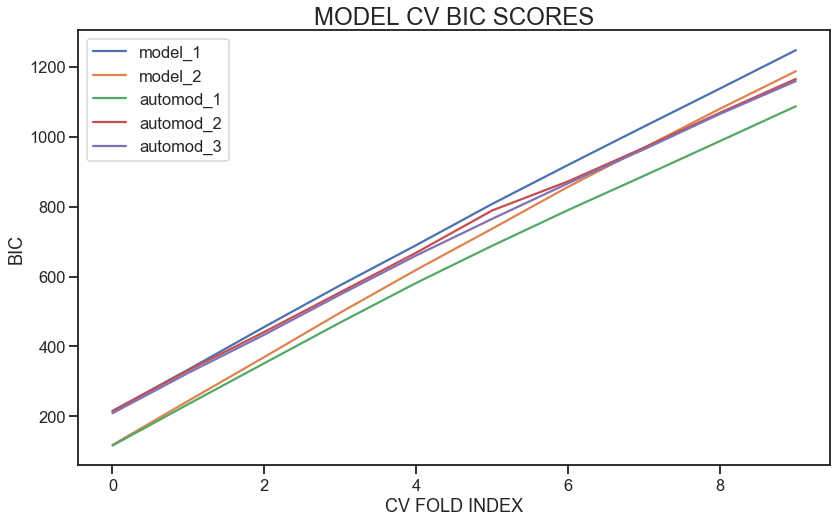

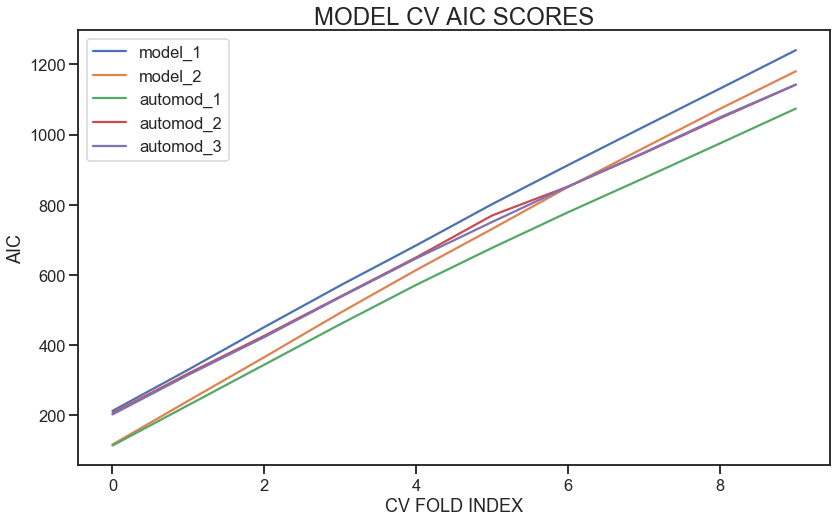

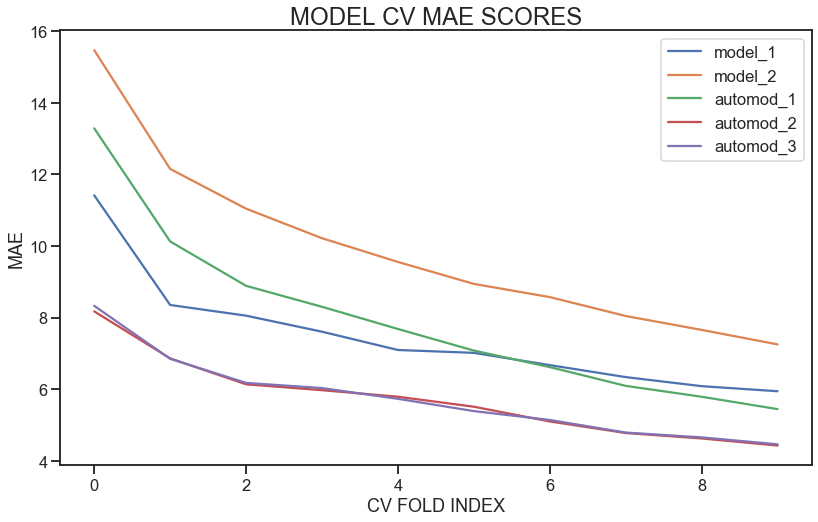

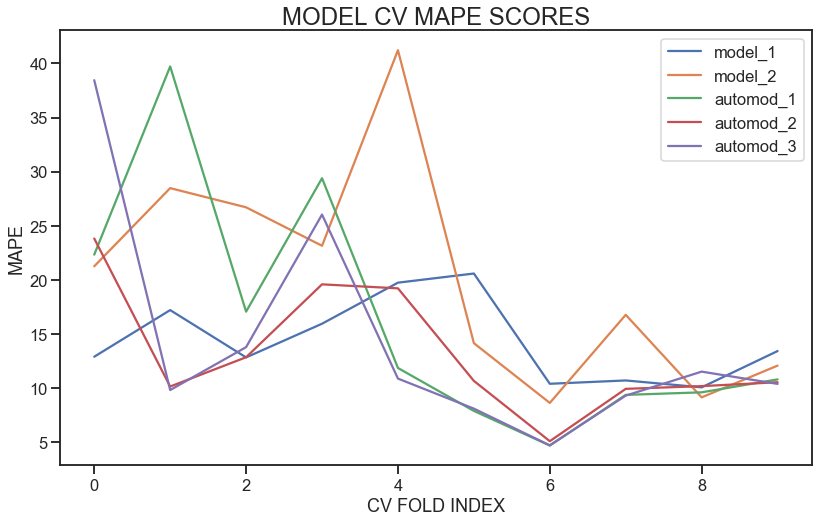

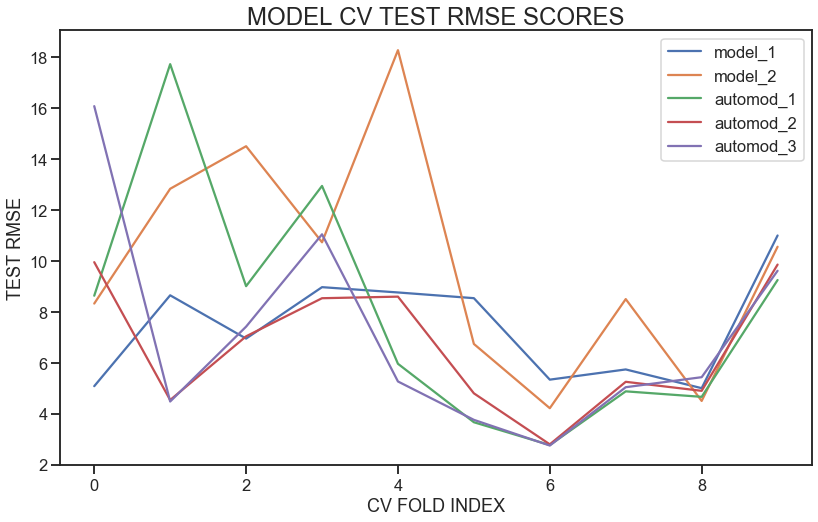

In [218]:
plot_models('BIC', 'MODEL CV BIC SCORES',model_eval=[list for list in cv_bic2.values()],
            labels=list(cv_bic2.keys()))
plot_models('AIC', 'MODEL CV AIC SCORES',model_eval=[list for list in cv_aic2.values()],
            labels=list(cv_aic2.keys()))
plot_models('MAE', 'MODEL CV MAE SCORES',model_eval=[list for list in cv_mae2.values()],
            labels=list(cv_mae2.keys()))
plot_models('MAPE', 'MODEL CV MAPE SCORES',model_eval=[list for list in cv_mape2.values()],
            labels=list(cv_mape2.keys()))
plot_models('TEST RMSE', 'MODEL CV TEST RMSE SCORES',model_eval=[list for list in cv_test_rmse2.values()],
            labels=list(cv_test_rmse2.keys()))


---

### Evaluation of Metrics

In [56]:
cv_aic2

{'model_1': array([ 213.03932287,  330.68378824,  451.77988518,  570.36393448,
         684.53851281,  801.96105552,  913.19692201, 1022.65473932,
        1131.05928855, 1240.54622914]),
 'model_2': array([ 117.27288186,  242.0394809 ,  366.16279498,  492.45232376,
         614.27183346,  731.43259816,  850.78964345,  962.3888838 ,
        1073.38658207, 1180.49003967]),
 'automod_1': array([ 114.36538879,  229.63046299,  344.73007659,  459.99102189,
         572.03397301,  677.48315072,  778.91670862,  876.30431416,
         975.00808851, 1074.18283361]),
 'automod_2': array([ 206.65934934,  319.69929555,  426.9983417 ,  538.59853596,
         650.2286275 ,  769.77987499,  851.99926633,  947.13580116,
        1046.38758118, 1142.36387991]),
 'automod_3': array([ 202.98567675,  315.85918338,  423.31837976,  536.82949925,
         647.48195907,  751.22604896,  852.23586916,  948.62118818,
        1049.22307554, 1142.53195212])}

Going to create my own evaluation metric. Since averaging the AIC values would be incorrect, I want to see what will happen if I calculate the *area under the curve*.

In [85]:
# Creating a list for each model's AIC values from cross-validation
aic_scores = {}
mod1 = []
for num in enumerate(cv_aic2['model_1'],1):
    mod1.append(num)
mod2 = []
for num in enumerate(cv_aic2['model_2'],1):
    mod2.append(num)
amod1 = []
for num in enumerate(cv_aic2['automod_1'],1):
    amod1.append(num)
amod2 = []
for num in enumerate(cv_aic2['automod_2'],1):
    amod2.append(num)
amod3 = []
for num in enumerate(cv_aic2['automod_3'],1):
    amod3.append(num)

In [95]:
print('Model 1 AUC:', auc(mod1[0],mod1[1]))
print('Model 2 AUC:', auc(mod2[0],mod2[1]))
print('Auto Model 1 AUC:', auc(amod1[0],amod1[1]))
print('Auto Model 2 AUC:', auc(amod2[0],amod2[1]))
print('Auto Model 3 AUC:', auc(amod3[0],amod3[1]))

Model 1 AUC: 35271.02259415707
Model 2 AUC: 14187.586865695886
Auto Model 1 AUC: 13129.438745649806
Auto Model 2 AUC: 33080.23390250138
Auto Model 3 AUC: 32101.50113336208


In [96]:
# Creating a list for each model's BIC values from cross-validation
mod1 = []
for num in enumerate(cv_bic2['model_1'],1):
    mod1.append(num)
mod2 = []
for num in enumerate(cv_bic2['model_2'],1):
    mod2.append(num)
amod1 = []
for num in enumerate(cv_bic2['automod_1'],1):
    amod1.append(num)
amod2 = []
for num in enumerate(cv_bic2['automod_2'],1):
    amod2.append(num)
amod3 = []
for num in enumerate(cv_bic2['automod_3'],1):
    amod3.append(num)

In [97]:
print('Model 1 AUC:', auc(mod1[0],mod1[1]))
print('Model 2 AUC:', auc(mod2[0],mod2[1]))
print('Auto Model 1 AUC:', auc(amod1[0],amod1[1]))
print('Auto Model 2 AUC:', auc(amod2[0],amod2[1]))
print('Auto Model 3 AUC:', auc(amod3[0],amod3[1]))

Model 1 AUC: 36067.44611590471
Model 2 AUC: 14512.10870956079
Auto Model 1 AUC: 13757.94927008923
Auto Model 2 AUC: 35818.796156339
Auto Model 3 AUC: 34018.28496909552


In [107]:
for model in cv_test_rmse2:
    print(model,': ',np.mean(cv_test_rmse2[model]))

model_1 :  7.403152505579295
model_2 :  9.919059631923911
automod_1 :  7.950430779771301
automod_2 :  6.6269329954465785
automod_3 :  7.088990358543386


In [109]:
for model in cv_mae2:
    print(model,': ',np.mean(cv_mae2[model]))

model_1 :  7.459088218755847
model_2 :  9.890857659807024
automod_1 :  7.931980334720483
automod_2 :  5.739227548836908
automod_3 :  5.756975934436655


In [110]:
for model in cv_mape2:
    print(model,': ',np.mean(cv_mape2[model]))

model_1 :  14.393284054682834
model_2 :  20.16751358364548
automod_1 :  16.284315422849247
automod_2 :  13.215630540778463
automod_3 :  14.311160847271953
